In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt 

In [4]:
 # Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Downloads/hawaii.sqlite") 

In [6]:
 # reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
 # We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
 # Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
 # Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

date_prcp_query = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >='2016-08-23', Measurement.date <='2017-08-23').\
order_by(Measurement.date).statement

In [11]:
# Save the query results as a Pandas DataFrame and set the index to the date column

date_prcp_df = pd.read_sql(date_prcp_query, engine).dropna()
date_prcp_df.head(5)

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79


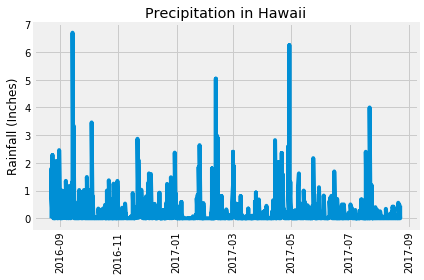

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data

date_prcp_df['date']  = pd.to_datetime(date_prcp_df['date'])
plt.plot(date_prcp_df['date'], date_prcp_df['prcp'])
plt.title("Precipitation in Hawaii")
plt.xlabel('')
plt.ylabel('Rainfall (Inches)')
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data 

date_prcp_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset

station_boolean = session.query(Measurement.station).distinct().count()== session.query(Station.station).distinct().count()
if station_boolean:
    num_station = session.query(Measurement.station).distinct().count()
    print(f' Number of Stations = {num_station}')


 Number of Stations = 9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
desc_observ = engine.execute('select station, count(station) from measurement group by station order by count(station) desc').fetchall()
desc_observ

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

active_station = desc_observ[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == active_station).all()

[(54.0, 71.66378066378067, 85.0)]

In [18]:
# Choose the station with the highest number of temperature observations.

station_id = desc_observ[0][0]
station_name = session.query(Station.name).filter(Station.station==desc_observ[0][0]).all()
print(f'Highest number of observations come from {station_name[0][0]}')

Highest number of observations come from WAIHEE 837.5, HI US


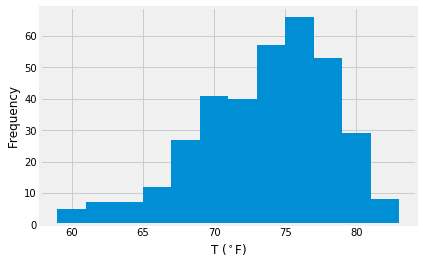

In [19]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_query = session.query(Measurement.tobs, Measurement.station).\
filter(Measurement.date >='2016-08-23', Measurement.date <='2017-08-23').\
filter(Measurement.station==station_id).\
order_by(Measurement.date).statement 

tobs_df = pd.read_sql(tobs_query, engine).dropna()
tobs_df.head(5)

x = tobs_df['tobs']

plt.hist(x, bins=12)
plt.xlabel(r'T ($^\circ$F)')
plt.ylabel('Frequency')
plt.show()

# Climate App

In [20]:
# Dependencies
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc
from flask import Flask, jsonify, request
from werkzeug.wrappers import Request, Response

In [21]:
engine = create_engine("sqlite:///Downloads/hawaii.sqlite") 

In [22]:
 # reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [23]:
 # We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
 # Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [25]:
 # Create our session (link) from Python to the DB
session = Session(engine)

In [26]:
app = Flask(__name__)


In [27]:
#Home Page 

@app.route("/")

def welcome(): "Hello"

In [28]:
# Convert the query results to a Dictionary using date as the key and prcp as the value.

# Return the JSON representation of your dictionary.

begin_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

@app.route("/api/v1.0/precipitation")

def precipitation():

    results = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > begin_date).\
                        order_by(Measurement.date).all()

    precipitation_data = []
    for prcp_data in results:
        prcp_data_dict = {}
        prcp_data_dict["Date"] = prcp_data.date
        prcp_data_dict["Precipitation"] = prcp_data.prcp
        precipitation_data.append(prcp_data_dict)
        

    return jsonify(precipitation_data)

In [29]:
# Return a JSON list of stations from the dataset.

@app.route("/api/v1.0/stations")

def stations():
    
    # Query all the stations
    results = session.query(Station).all()

    all_stations = []
    for stations in results:
        stations_dict = {}
        stations_dict["Station"] = stations.station
        stations_dict["Station Name"] = stations.name
        stations_dict["Latitude"] = stations.latitude
        stations_dict["Longitude"] = stations.longitude
        stations_dict["Elevation"] = stations.elevation
        all_stations.append(stations_dict)
    
    return jsonify(all_stations)

In [30]:
@app.route("/api/v1.0/tobs")

def tobs():
    
    # query for the dates and temperature observations from a year from the last data point.
   
    results = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                    group_by(Measurement.date).\
                    filter(Measurement.date > begin_date).\
                    order_by(Measurement.station).all()
                    
# Return a JSON list of Temperature Observations (tobs) for the previous year.

    temp_data = []
    for tobs_data in results:
        tobs_data_dict = {}
        tobs_data_dict["Station"] = tobs_data.station
        tobs_data_dict["Date"] = tobs_data.date
        tobs_data_dict["Temperature"] = tobs_data.tobs
        temp_data.append(tobs_data_dict)
    
    return jsonify(temp_data)

In [31]:
@app.route("/api/v1.0/temp/", methods=['get'])

# When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.

def start_stats(start=None):
    
    start = request.args.get('start')
    
    # Query all the stations and for the given date. 
    results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.date >= start).all()

    temp_stats = []
    
    for Tmin, Tmax, Tavg in results:
        temp_stats_dict = {}
        temp_stats_dict["Minimum Temp"] = Tmin
        temp_stats_dict["Maximum Temp"] = Tmax
        temp_stats_dict["Average Temp"] = Tavg
        temp_stats.append(temp_stats_dict)
    
    return jsonify(temp_stats)

In [32]:
@app.route("/api/v1.0/temp-range/", methods=['get'])
def calc_stats(start=None, end=None):
   
    # When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.

    start = request.args.get('start')
    end   = request.args.get('end') 
    
    # Query all the stations and for the given range of dates. 
    results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.date >= start).filter(Measurement.date <= end).all()

    begin_end_stats = []
    
    for Tmin, Tmax, Tavg in results:
        begin_end_stats_dict = {}
        begin_end_stats_dict["Minimum Temp"] = Tmin
        begin_end_stats_dict["Maximum Temp"] = Tmax
        begin_end_stats_dict["Average Temp"] = Tavg
        begin_end_stats_dict['start']=start
        begin_end_stats_dict['end']=end
        begin_end_stats.append(begin_end_stats_dict)
    
    return jsonify(begin_end_stats)

In [33]:
if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with stat


SystemExit: 1

C:\Users\John\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
